# Using survey data to model voter choice

Could we predict which way somebody voted in the 2019 general election based upon their answers to survey questions and some descriptive characteristics? That's what I'm going to try and do.

In this notebook I'll be using survey data collected in a panel survey carried out by the British Election Study. The data can be found here: https://www.britishelectionstudy.com/data-objects/panel-study-data/. The dataset is very large (about 97000x8080). The panel study is carried out in waves with some questions being asked over multiple waves and some not. The survey is constantly changing. Questions range from abstract social matters to opinions about how the economy is currently doing. Unfortunatley JuptyerLab crashes whenever I tried to load in the SPSS file using pandas so I've had use PSPP to convert the data into a csv file. This transformation wasn't the friendliest (e.g. in many columns that should have just had numeric values, values were represented as both strings and numbers) but it's nothing that can't be dealt with in data preprocessing. The transformation also gave me numbered representations of survey answers rather than the string actual answers. For the purposes of machine learning, this is very helpful in places but will require some further processing in other areas.

In this notebook I'll go through:
- Featrue and target engineering and preprocessing
- Exploratory visualisation
- Model creation and hyperparameter optimisation:
   - Random forest
   - Neural network

I'll start by importing some of the packages we'll be using. The utilities import was created by myself for use with other parts of this project and its helpgul here. There's lots of other code in it and feel free to take a look.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utilities as election_helper

ge_colour_map = election_helper.get_ge_colour_map()
party_num_to_name = {
    1: "con",
    2: "lab",
    3: "ld",
    4: "snp",
    5: "pc",
    6: "brexit",
    7: "green"
}

Respondents often leave questions they have answered before blank but some don't answer them at all. Below I define a function that will allow us to search through a dataframe and it's rows to find the most recent response to a survey question for each respondent. For those that don't answer a question, this is represented using None. However, it's important that we aren't using data that's too out of date as people's opinions may have changed so I only look for people's opinions just prior to the 2019 election campaigns kicking off up to the post-election survey.

In [2]:
def find_most_recent_answer(df, columns, invalid_values=["9999", "", " ", 9999, np.nan, 99, 98]):
    # Returns a list of values representing respondents most recent answer to a survey question. None represents a respondent not giving an answer.
    #
    # Parameters:
    # - df (DataFrame): dataframe to use for getting responses
    # - columns (array of strings): ordered array of survey question column names to inspect for answers going from the most recent to least recent
    # - invalid_values (array of strings): a list of values to deem as invalid repsonses and thus ignore
    
    values = np.array([])
    for index, row in df.iterrows():
        new_value = None
        for column in columns:
            if (not (row[column] in invalid_values)):
                new_value = row[column]
                break
        values = np.append(values, new_value)
    return values

def print_columns_containing_string(df, string):
    print([i for i in df.columns if (string in i.lower())])

I'm going to use a question asking who respondetns voted for in the 2019 election from wave 19 of the survey as the target for modelling. Therefore, I'm going to load in the panel data set and then filter for only those respondents who gave a valid response to the target value. I've written the result of this filter to a new csv and the panel data takes a long time to load in so feel free to skip this bit.

In [3]:
original_data_df = pd.read_csv("csvs/bes_datasets/wave1-19BES.csv")
bes_w1_w19_df = original_data_df[~original_data_df["p_past_vote_2019"].isin([9999, "9999", " "])]
bes_w1_w19_df.to_csv("csvs/bes_datasets/BES_w1-19_for_w19_respondents.csv", index=False)

/home/graeme/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,38,57,89,265,7116,7118,7124,7125,7126,7127,7128,7129,7130,7137,7138,7139,7140,7141,7142,7143,7146,7147,7148,7149,7150,7151,7152,7153,7154,7155,7156,7157,7158,7159,7160,7161,7162,7163,7164,7165,7166,7167,7168,7169,7170,7171,7172,7173,7174,7175,7176,7177,7178,7179,7180,7181,7182,7183,7184,7185,7186,7187,7188,7189,7283,7284,7285,7286,7287,7288,7289,7318,7319,7320,7321,7322,7323,7408,7409,7410,7411,7412,7413,7415,7428,7429,7432,7433,7439,7721,7722,7723,7724,7725,7726,7727,7728,7729,7730,7731,7732,7733,7734,7735,7736,7742,7743,7744,7747,7748,7749,7750,7755,7882,7887,7993,8012,8014,8026,8044,8074) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
bes_w1_w19_df = pd.read_csv("csvs/bes_datasets/BES_w1-19_for_w19_respondents.csv")
modelling_df = pd.DataFrame()

/home/graeme/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (184,7119,7121,7123,7161,7167,7169,7174,7181,7182,7183,7184,7185,7186,7433,7722,7723,7725,7726,7727,7728,7729,7730,7732,7733,7734,7747,7748,7755,7882,7993) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Feature engineering

Now, I'm going to assemble the target and features I'll use for modelling. To start with, I'll go through the panel data and engineer different columns to get respondents answers to questions. Some of this will be simple (e.g. pd.to_numeric()) and some of this will be a little more complex, pulling in different datasets from time to time.

### Target: 2019 general election vote

In [5]:
bes_w1_w19_df["p_past_vote_2019"] = pd.to_numeric(bes_w1_w19_df["p_past_vote_2019"], errors="coerce")
bes_w1_w19_df["generalElectionVoteW19"] = pd.to_numeric(bes_w1_w19_df["generalElectionVoteW19"], errors="coerce")

In [6]:
bes_w1_w19_df = bes_w1_w19_df[bes_w1_w19_df["generalElectionVoteW19"].isin([1, 2, 3, 4, 5, 7, 12])]
bes_w1_w19_df = bes_w1_w19_df[bes_w1_w19_df["p_past_vote_2019"].isin([1, 2, 3, 4, 5, 7, 12])]

bes_w1_w19_df.loc[bes_w1_w19_df["generalElectionVoteW19"] == 12, "generalElectionVoteW19"] = 6
bes_w1_w19_df.loc[bes_w1_w19_df["p_past_vote_2019"] == 12, "p_past_vote_2019"] = 6

modelling_df["ge_2019_vote"] = find_most_recent_answer(bes_w1_w19_df, ["generalElectionVoteW19", "p_past_vote_2019"])

Text(0, 0.5, 'Number of examples')

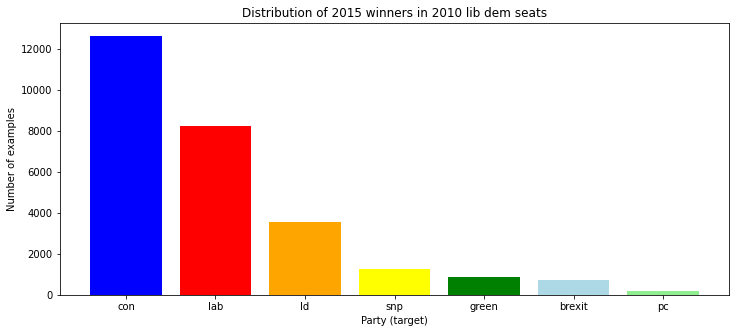

In [7]:
fig, axes = plt.subplots(figsize=(12,5))

val_counts = modelling_df["ge_2019_vote"].value_counts()
axes.bar([party_num_to_name[party] for party in val_counts.index],
        val_counts.values,
        color=[ge_colour_map[party_num_to_name[party]] for party in val_counts.index])
axes.set_title("Distribution of 2015 winners in 2010 lib dem seats")
axes.set_xlabel("Party (target)")
axes.set_ylabel("Number of examples")

### Features: left right values survey questions

In [8]:
modelling_df["lr1"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["lr1W17", "lr1W16", "lr1W14W15"]), errors="coerce")
modelling_df["lr2"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["lr2W17", "lr2W16", "lr2W14W15"]), errors="coerce")
modelling_df["lr3"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["lr3W17", "lr3W16", "lr3W14W15"]), errors="coerce")
modelling_df["lr4"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["lr4W17", "lr4W16", "lr4W14W15"]), errors="coerce")
modelling_df["lr5"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["lr5W17", "lr5W16", "lr5W14W15"]), errors="coerce")

/home/graeme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


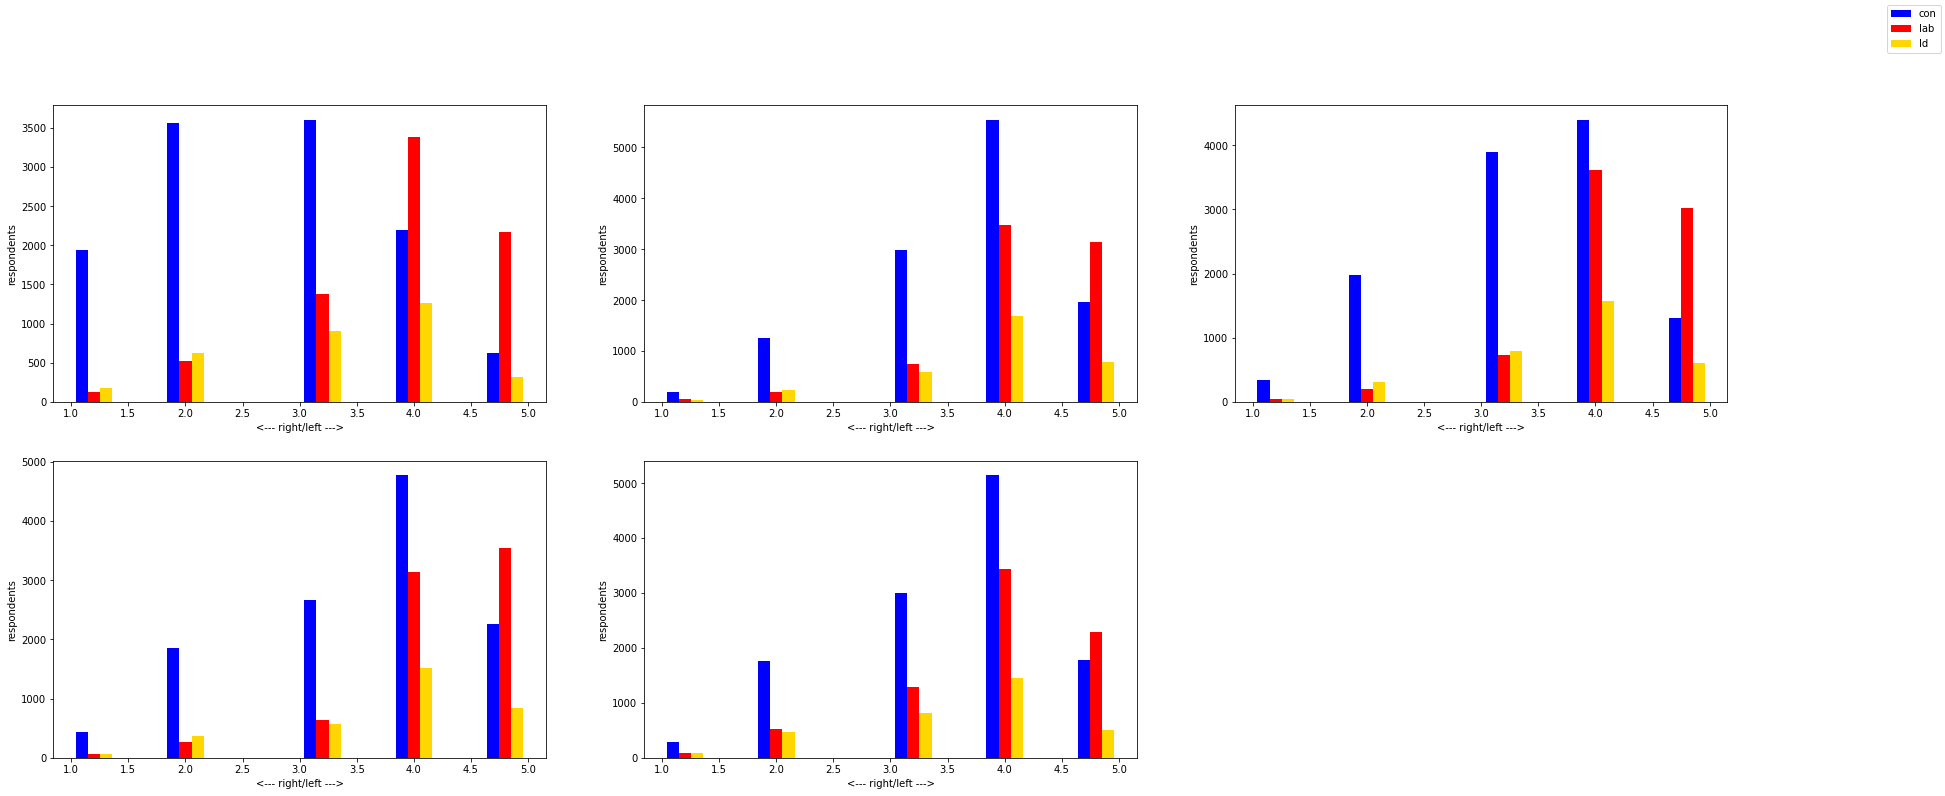

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(30,12))

for i in range(0, 5):
    axes[int(i / 3)][i % 3].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["lr" + str(i + 1)],
            modelling_df[modelling_df["ge_2019_vote"] == 2]["lr" + str(i + 1)],
            modelling_df[modelling_df["ge_2019_vote"] == 3]["lr" + str(i + 1)]],
        color=["blue", "red", "gold"],
        label=["con", "lab", "ld"])
    axes[int(i / 3)][i % 3].set_xlabel("<--- right/left --->")
    axes[int(i / 3)][i % 3].set_ylabel("respondents")

axes[1][2].axis("off")

fig.legend(axes[0][0], labels=["con", "lab", "ld"])

print()

### Features: liberal authoritarian values survey questions

In [10]:
modelling_df["al1"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["al1W17", "al1W16", "al1W14W15"]), errors="coerce")
modelling_df["al2"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["al2W17", "al2W16", "al2W14W15"]), errors="coerce")
modelling_df["al3"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["al3W17", "al3W16", "al3W14W15"]), errors="coerce")
modelling_df["al4"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["al4W17", "al4W16", "al4W14W15"]), errors="coerce")
modelling_df["al5"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["al5W17", "al5W16", "al5W14W15"]), errors="coerce")

/home/graeme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


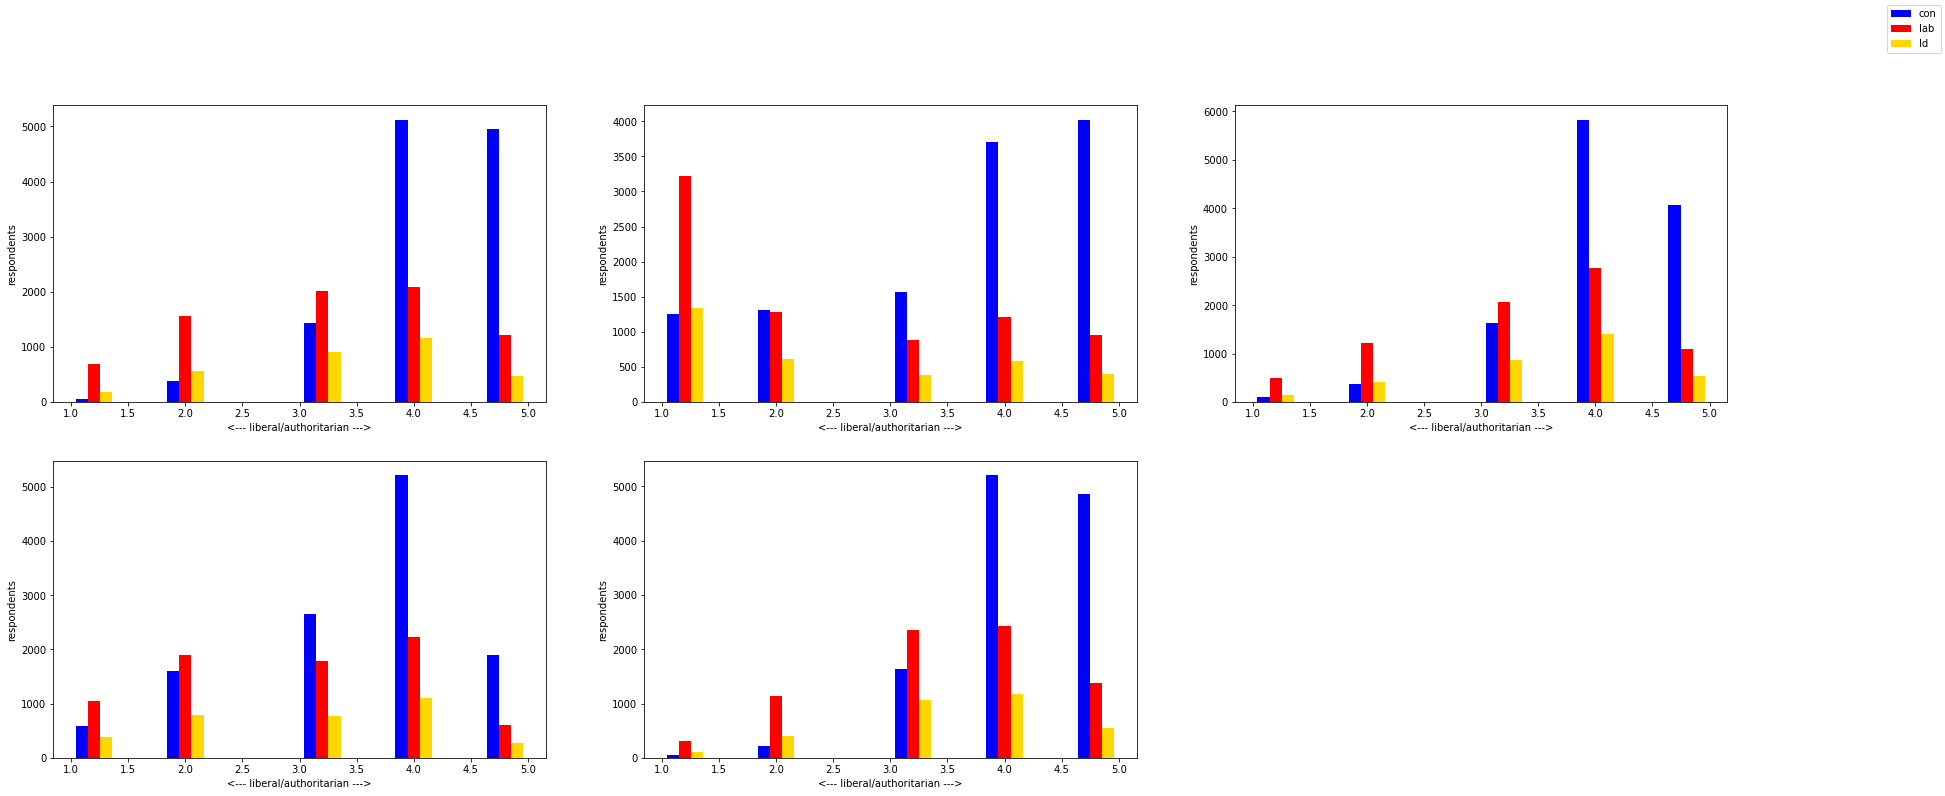

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(30,12))

for i in range(0, 5):
    axes[int(i / 3)][i % 3].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["al" + str(i + 1)],
            modelling_df[modelling_df["ge_2019_vote"] == 2]["al" + str(i + 1)],
            modelling_df[modelling_df["ge_2019_vote"] == 3]["al" + str(i + 1)]],
        color=["blue", "red", "gold"],
        label=["con", "lab", "ld"])
    axes[int(i / 3)][i % 3].set_xlabel("<--- liberal/authoritarian --->")
    axes[int(i / 3)][i % 3].set_ylabel("respondents")
    
axes[1][2].axis("off")

fig.legend(axes[0][0], labels=["con", "lab", "ld"])

print()

### Features: EU survey questions

In [12]:
# euRefVote:
# - 0: Remain
# - 1: Leave
# - 9999: Don't know
# - 2: I would/will not vote

# euRefDoOver:
# - 0: No
# - 1: Yes
# - 9999: Don't know

modelling_df["new_eu_ref_vote"] = find_most_recent_answer(bes_w1_w19_df, ["euRefVoteW19", "euRefVoteW18", "euRefVoteW17", "euRefVoteW16", "euRefVoteW15"])
modelling_df["should_there_be_a_new_eu_ref"] = find_most_recent_answer(bes_w1_w19_df, ['euRefDoOverW19', 'euRefDoOverW18', 'euRefDoOverW17', 'euRefDoOverW16', 'euRefDoOverW15'])

modelling_df["new_eu_ref_vote"] = pd.to_numeric(modelling_df["new_eu_ref_vote"], errors="coerce")
modelling_df.loc[modelling_df["new_eu_ref_vote"] == 2, "new_eu_ref_vote"] = None
modelling_df["should_there_be_a_new_eu_ref"] = pd.to_numeric(modelling_df["should_there_be_a_new_eu_ref"], errors="coerce")

# EUIntegrationSelf: 10 = should be pushed further, 0 = gone too far
modelling_df["opinion_on_eu_integration"] = find_most_recent_answer(bes_w1_w19_df, ["EUIntegrationSelfW19", "EUIntegrationSelfW18", "EUIntegrationSelfW17", "EUIntegrationSelfW16", "EUIntegrationSelfW15"])
modelling_df["opinion_on_eu_integration"] = pd.to_numeric(modelling_df["opinion_on_eu_integration"], errors="coerce")

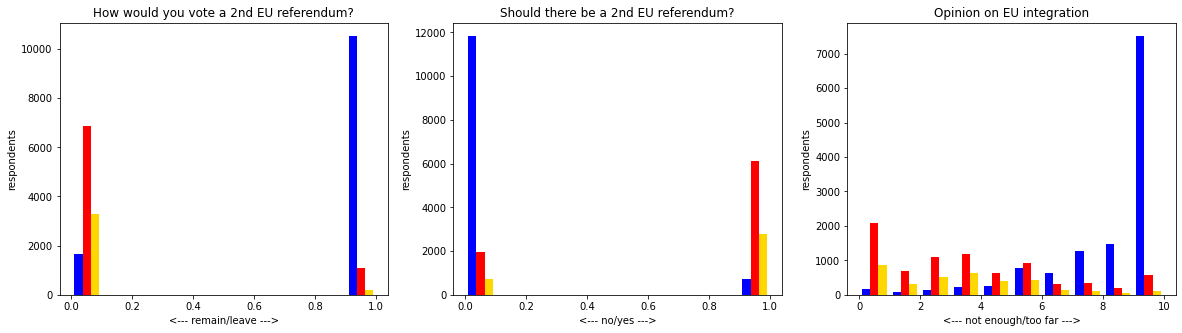

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["new_eu_ref_vote"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["new_eu_ref_vote"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["new_eu_ref_vote"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[0].set_xlabel("<--- remain/leave --->")
axes[0].set_ylabel("respondents")
axes[0].set_title("How would you vote a 2nd EU referendum?")

axes[1].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["should_there_be_a_new_eu_ref"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["should_there_be_a_new_eu_ref"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["should_there_be_a_new_eu_ref"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[1].set_xlabel("<--- no/yes --->")
axes[1].set_ylabel("respondents")
axes[1].set_title("Should there be a 2nd EU referendum?")

axes[2].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["opinion_on_eu_integration"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["opinion_on_eu_integration"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["opinion_on_eu_integration"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[2].set_xlabel("<--- not enough/too far --->")
axes[2].set_ylabel("respondents")
axes[2].set_title("Opinion on EU integration")

print()

### Features: Economy survey questions

In [14]:
# changeEconomy:
# 1: Getting a lot worse
# 2: Getting a little worse
# 3: Staying about the same
# 4: Getting a little better
# 5: Getting a lot better

modelling_df["perceived_change_in_economy"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["changeEconomyW18", "changeEconomyW17", "changeEconomyW16"]), errors="coerce")

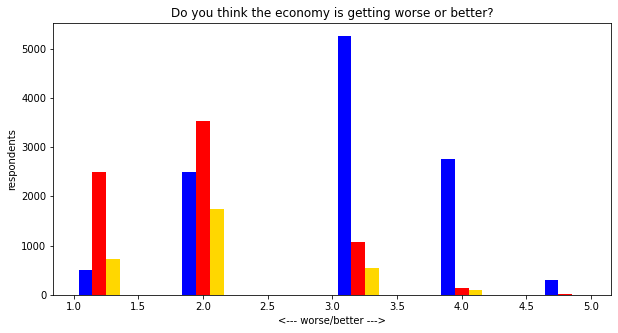

In [15]:
fig, axes = plt.subplots(figsize=(10,5))

axes.hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["perceived_change_in_economy"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["perceived_change_in_economy"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["perceived_change_in_economy"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes.set_xlabel("<--- worse/better --->")
axes.set_ylabel("respondents")
axes.set_title("Do you think the economy is getting worse or better?")

print()

### Features: Other suvery questions

In [16]:
# Tactical vote
tactical_vote = np.array([])
for value in bes_w1_w19_df["reasonForVoteW19"].values:
    if (value == 4):
        tactical_vote = np.append(tactical_vote, 1)
    else:
        tactical_vote = np.append(tactical_vote, 0)

modelling_df["tactical_vote"] = tactical_vote

# Trust in MPs
modelling_df["trust_in_mps"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["trustMPsW19", "trustMPsW18", "trustMPsW17", "trustMPsW16", "trustMPsW15"]), errors="coerce")

# Attention to politics
modelling_df["attention_to_politics"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["polAttentionW19", "polAttentionW17", "polAttentionW16", "polAttentionW15"]), errors="coerce")

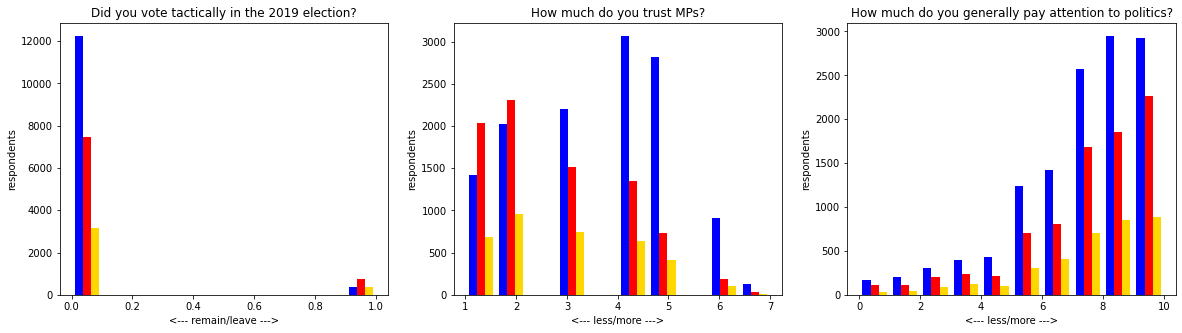

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["tactical_vote"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["tactical_vote"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["tactical_vote"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[0].set_xlabel("<--- remain/leave --->")
axes[0].set_ylabel("respondents")
axes[0].set_title("Did you vote tactically in the 2019 election?")

axes[1].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["trust_in_mps"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["trust_in_mps"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["trust_in_mps"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[1].set_xlabel("<--- less/more --->")
axes[1].set_ylabel("respondents")
axes[1].set_title("How much do you trust MPs?")

axes[2].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["attention_to_politics"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["attention_to_politics"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["attention_to_politics"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[2].set_xlabel("<--- less/more --->")
axes[2].set_ylabel("respondents")
axes[2].set_title("How much do you generally pay attention to politics?")

print()

In [18]:
# Like of the leaders
modelling_df["opinon_on_corbyn"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["likeCorbynW19", "likeCorbynW18", "likeCorbynW17", "likeCorbynW16", "likeCorbynW15"]), errors="coerce")
modelling_df["opinon_on_johnson"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["likeJohnsonW19", "likeJohnsonW18", "likeJohnsonW17",]), errors="coerce")
modelling_df["opinon_on_swinson"] = pd.to_numeric(find_most_recent_answer(bes_w1_w19_df, ["likeSwinsonW19", "likeSwinsonW18", "likeSwinsonW17"]), errors="coerce")

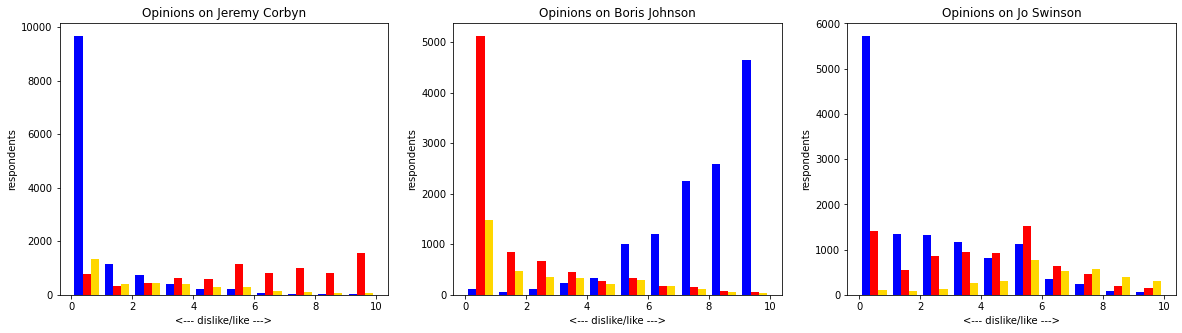

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["opinon_on_corbyn"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["opinon_on_corbyn"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["opinon_on_corbyn"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[0].set_xlabel("<--- dislike/like --->")
axes[0].set_ylabel("respondents")
axes[0].set_title("Opinions on Jeremy Corbyn")

axes[1].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["opinon_on_johnson"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["opinon_on_johnson"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["opinon_on_johnson"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[1].set_xlabel("<--- dislike/like --->")
axes[1].set_ylabel("respondents")
axes[1].set_title("Opinions on Boris Johnson")

axes[2].hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["opinon_on_swinson"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["opinon_on_swinson"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["opinon_on_swinson"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])
axes[2].set_xlabel("<--- dislike/like --->")
axes[2].set_ylabel("respondents")
axes[2].set_title("Opinions on Jo Swinson")

print()

### Features: Education

In [20]:
edlevel_mapping = {
    1: 0, #'No qualifications',
    2: 2, #'Level 2',
    3: 2, #'Level 2',
    4: 1, #'Level 1',
    5: 1, #'Level 1',
    6: 2, #'Level 2',
    7: 2, #'Level 2',
    8: 1, #'Level 1',
    9: 2, #'Level 2',
    10: 2, #'Level 2',
    11: 3, #'Level 3',
    12: 3, #'Level 3',
    13: 4, #'Level 4/5',
    14: 4, #'Level 4/5',
    15: 4, #'Level 4/5',
    16: 4, #'Level 4/5',
    17: 4, #'Level 4/5',
    18: 0, #'Other',
    19: 0, #''No qualifications',
    20: 0, #''No qualifications',
    98: None,
    99: None,
    '1': 0, #'No qualifications',
    '2': 2, #'Level 2',
    '3': 2, #'Level 2',
    '4': 1, #'Level 1',
    '5': 1, #'Level 1',
    '6': 2, #'Level 2',
    '7': 2, #'Level 2',
    '8': 1, #'Level 1',
    '9': 2, #'Level 2',
    '10': 2, #'Level 2',
    '11': 3, #'Level 3',
    '12': 3, #'Level 3',
    '13': 4, #'Level 4/5',
    '14': 4, #'Level 4/5',
    '15': 4, #'Level 4/5',
    '16': 4, #'Level 4/5',
    '17': 4, #'Level 4/5',
    '18': 0, #''Other',
    '19': 0, #''No qualifications',
    '20': 0, #''No qualifications',
    '98': None,
    '99': None
}

modelling_df["education_level"] = pd.to_numeric(bes_w1_w19_df["p_educationW19"].map(edlevel_mapping), errors="coerce")

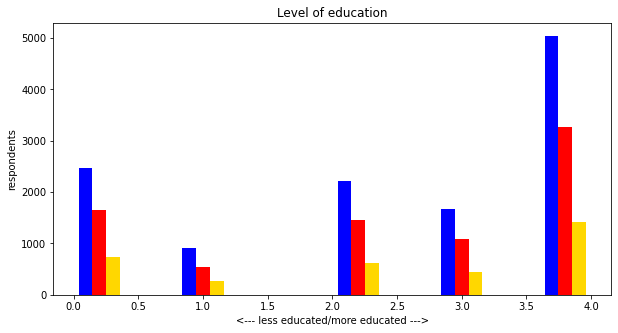

In [21]:
fig, axes = plt.subplots(figsize=(10,5))

axes.hist(x=[modelling_df[modelling_df["ge_2019_vote"] == 1]["education_level"],
                    modelling_df[modelling_df["ge_2019_vote"] == 2]["education_level"],
                    modelling_df[modelling_df["ge_2019_vote"] == 3]["education_level"]],
                color=["blue", "red", "gold"],
                label=["con", "lab", "ld"])

axes.set_xlabel("<--- less educated/more educated --->")
axes.set_ylabel("respondents")
axes.set_title("Level of education")

print()

### Features: Profile description

In [22]:
modelling_df["gender"] = pd.to_numeric(bes_w1_w19_df["gender"], errors="coerce")
modelling_df["age"] = pd.to_numeric(bes_w1_w19_df["ageW19"], errors="coerce")
modelling_df["social_grade"] = pd.to_numeric(bes_w1_w19_df["p_socgradeW19"], errors="coerce")
# 8 = unknown
modelling_df.loc[modelling_df["social_grade"] == 8, "social_grade"] = None
modelling_df["country"] = pd.to_numeric(bes_w1_w19_df["countryW19"], errors="coerce").values

### Features: Constituency level

Here I'm going to pull in another dataset that I have made for other parts of this project. It includes data about constituencies. I'm going to extract some features from this data. For example, I'm going to features that describe where the Conservatives, Labour and the Liberal Democrats finished in each constituency in the past 2 elections. This will be encoded using the one-hot method.

In [23]:
constits_df = pd.read_csv("csvs/final_datasets/constits.csv")
pcon_codes_df = pd.read_csv("csvs/constituency_data/constit_pcon.csv")

constit_cols_to_include = ["level_4_plus", "leave_share", "region_name"]

modelling_df["pcon"] = pd.to_numeric(bes_w1_w19_df["pconW19"], errors="coerce")


# Calculate the 1st placed, 2nd placed and 3rd placed parties and encode for selected parties
parties_to_record = ["con", "lab", "ld"]
parties_to_measure = ["con", "lab", "ld", "ukip", "green", "snp", "pc"]
years = ["2017", "2015"]
cols_to_fill = set()
for year in years:
    for party in parties_to_record:
        cols_to_fill.add(year + "_" + party + "_first")
        cols_to_fill.add(year + "_" + party + "_second")
        cols_to_fill.add(year + "_" + party + "_third")

constits_df = pd.merge(constits_df, pcon_codes_df, left_on="ons_id", right_on="pconId")
pd.get_dummies(constits_df["region_name"], prefix="region_")

constit_features_df = pd.DataFrame(columns=np.concatenate((["pcon"], list(cols_to_fill), constit_cols_to_include)))

for index, row in constits_df.iterrows():
    new_row_attributes = {}
    temp_cols_to_fill = cols_to_fill.copy()
    for year in  years:
        party_to_votes = {}
        for party in parties_to_measure:
            party_to_votes[party] = row[year + "_" + party]
        sorted_parties = {k: v for k, v in sorted(party_to_votes.items(), key=lambda item: item[1], reverse=True)}
        ordered_parties = list(sorted_parties.keys())
        # first
        first_col_name = year + "_" + ordered_parties[0] + "_first"
        if (first_col_name in temp_cols_to_fill):
            new_row_attributes[first_col_name] = 1
            temp_cols_to_fill.remove(first_col_name)
        # second
        second_col_name = year + "_" + ordered_parties[1] + "_second"
        if (second_col_name in temp_cols_to_fill):
            new_row_attributes[second_col_name] = 1
            temp_cols_to_fill.remove(second_col_name)
        # third
        third_col_name = year + "_" + ordered_parties[2] + "_third"
        if (third_col_name in temp_cols_to_fill):
            new_row_attributes[third_col_name] = 1
            temp_cols_to_fill.remove(third_col_name)
    for col_name in temp_cols_to_fill:
        new_row_attributes[col_name] = 0
    new_row_attributes["pcon"] = int(row["pconNo"])
    
    for col in constit_cols_to_include:
        new_row_attributes[col] = row[col]
        
    constit_features_df = constit_features_df.append(new_row_attributes , ignore_index=True)

# One hot encode region
region_one_hot = pd.get_dummies(constit_features_df["region_name"], prefix="region")
constit_features_df = constit_features_df.join(region_one_hot)
constit_features_df.drop("region_name", axis=1, inplace=True)

# There is an issue here
modelling_df = pd.merge(modelling_df, constit_features_df, on="pcon")

Finally, I'll write these results to a CSV.

In [24]:
modelling_df.to_csv("csvs/bes_datasets/voter_choice.csv", index=False)

# Modelling

Before buidling any models, I'm going to set a few things up. 

I'm going to import some of the packages I'll be using and then I'm going to define a function that will transform our dataset into a format suitable for modelling. This means that I'll have to deal with invalid values and I'll provide a couple of options which will include multiple imputation. 

Finally, I'll define a function that will be passed the features and targets as well as a model and preform a k-fold cross validation. It will return a set of metrics including a confusion matrix visualisation. This function will also use SMOTE to create synthetic data for the training data of each fold. I'm going to use SMOTE as we're dealing with imbalanced data e.g. far more examples of Conservatives than Liberal Democrats.

For the example modelling I've done below, I've restricted the target classes to just Conservative voters, Labour voters and Liberal Democrat voters.

In [26]:
# You sometimes have to run this twice, there's an inititally an error returned when importing SMOTE but it resolves on a second try
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from impyute.imputation.cs import mice
import seaborn as sns

In [27]:
modelling_df = pd.read_csv("csvs/bes_datasets/voter_choice.csv")

In [28]:
# Default: England only
def load_final_dataset(countries=[1], na_handler="median", parties=["con", "lab", "ld"]):
    modelling_df = pd.read_csv("csvs/bes_datasets/voter_choice.csv")
    
    modelling_df = modelling_df[modelling_df["country"].isin(countries)]
    modelling_df["ge_2019_vote"] = modelling_df["ge_2019_vote"].map(party_num_to_name)
    modelling_df = modelling_df[modelling_df["ge_2019_vote"].isin(parties)]
    
    targets = modelling_df["ge_2019_vote"]
    features = modelling_df.drop(["ge_2019_vote", "country", "pcon"], axis=1)
    
    if (na_handler == "multiple_imputation"):
        features = pd.DataFrame(mice(features.values))
    elif (na_handler == "drop"):
        features = features.dropna()
    elif (na_handler == "median" or na_handler == "mean"):
        for column in features.columns:
            if (na_handler == "median"):
                features[column] = features[column].fillna(features[column].median())
            else:
                features[column] = features[column].fillna(features[column].mean())
    else:
        raise Exception("na_handler not recognised")
    
    return features, targets

In [29]:
features, targets = load_final_dataset(na_handler="multiple_imputation", parties=["con", "lab", "ld"])

In [30]:
def display_analytics(real_values, predictions, cm_labels):
    cm = confusion_matrix(real_values, predictions)
    
    print(metrics.classification_report(real_values, predictions))
    
    normalised_cm = np.ones((len(cm), len(cm)))
    for row in range(0, len(cm)):
        row_sum = np.sum(cm[row])
        for i in range(0, len(cm[0])):
            normalised_cm[row][i] = float(cm[row][i])/float(row_sum)
            
    f = sns.heatmap(normalised_cm, annot=True, xticklabels=cm_labels, yticklabels=cm_labels, cmap="viridis")
    f.set_xlabel("Predicted labels")
    f.set_ylabel("True labels")
    
    return cm

def kFold_cross_validation_using_SMOTE(features, targets, k, model, parties=["con", "lab", "ld"]):
    kf = KFold(n_splits=k)
    oversample = SMOTE()
    empty_model = clone(model)
    
    combined_predictions = np.array([])
    combined_real_values = np.array([])
    accuracy_scores = np.array([])
    
    for train_index, test_index in kf.split(features):
        X_train = features.values[train_index]
        y_train = targets.values[train_index]
        X_test = features.values[test_index]
        y_test = targets.values[test_index]
        
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        
        model = empty_model
        model.fit(X_train, y_train)
        
        predicitions = model.predict(X_test)
        
        combined_predictions = np.concatenate((combined_predictions, predicitions), axis=None)
        combined_real_values = np.concatenate((combined_real_values, y_test))
        
        accuracy_scores = np.append(accuracy_scores, accuracy_score(y_test, predicitions))

    print("Average accuracy: " + str(np.mean(accuracy_scores)))
    print("Accuracy sd:      " + str(np.std(accuracy_scores)))
    print()
    
    display_analytics(combined_real_values, combined_predictions, parties)

# Random Forest

The first model I'm going to try is a random forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. It is an ensemble method meaning that multiple models are used to construct a single model. I'm first going to use the deafult hyperparameters and see how it does.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

Average accuracy: 0.8550966457888819
Accuracy sd:      0.006146749825273614

              precision    recall  f1-score   support

         con       0.93      0.95      0.94     10840
         lab       0.82      0.84      0.83      6953
          ld       0.63      0.56      0.60      3083

    accuracy                           0.86     20876
   macro avg       0.80      0.78      0.79     20876
weighted avg       0.85      0.86      0.85     20876




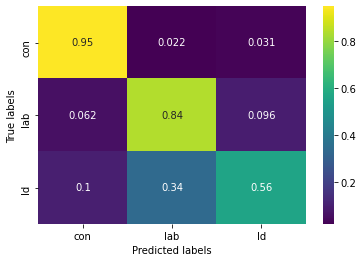

In [32]:
rfc = RandomForestClassifier()
# ["brexit", "con", "green", "lab", "ld"]
cm = kFold_cross_validation_using_SMOTE(features, targets, 5, rfc, parties=["con", "lab", "ld"])
print()

Though preformance slightly differs from run to run, the default model is attaining around 85-87% accuracy. Analysis:
- The model works very well for Conservative voters with precision and recall of both around 95%.
- Unexpectedly, the model struggles much more when it comes to differentiating between Labour and Liberal democrat voters. It certainly deals better with Labour voters, with a precision of 0.82. The primary problem is Liberal Democrat voters being incorrectly classified as Labour voters. This occurs with 34% of the Liberal Democrat voters.
- The model is very stable as there is a small standard deviation of accuracy between folds.

### Random Forest hyperparameter optimisation
We're going to optimise the following hyperparameters of our random forest:
- n_estimators: number of trees
- max_features: number of features considered when splitting
- max_depth: max depth of the tree
- min_samples_leaf: the minimum number of sample required to be a leaf node
- boostrap: whether or not to use bootstrap samples when building trees

We're going to use a two-step approach. First we are going to use a randomised search algorithm. This algorithm randomly samples combinations from a specified set of hyperparameters. After we get the results from that algorithm, we'll use an exhaustive grid search to explore the hyperparameter space around the optimal combination that was found by the randomised search.

In [ ]:
rfc = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1900, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# n_iter: number of parameter settings that are to be sampled
# cv: <cv>-fold cross validation method to use
randomised_search_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=hyperparameters, 
                            n_iter=50, cv=3, verbose=10, n_jobs=-1)

randomised_search_rfc.fit(features, targets)

print(randomised_search_rfc.best_estimator_)

In [ ]:
#saved_vest_random_rfc = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#                       criterion='gini', max_depth=90, max_features='sqrt',
#                       max_leaf_nodes=None, max_samples=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=100,
#                       n_jobs=None, oob_score=False, random_state=None,
#                       verbose=0, warm_start=False)

In [ ]:
rfc = RandomForestClassifier()

hyperparameters = {
    'n_estimators': [90, 100, 110],
    'max_features': ["sqrt"],
    'max_depth': [80, 90, 100],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search_rfc = GridSearchCV(estimator = rfc, param_grid = hyperparameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_estimator_)

In [37]:
saved_best_rfc = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Average accuracy: 0.8545697340950283
Accuracy sd:      0.00516105282165193

              precision    recall  f1-score   support

         con       0.93      0.95      0.94     10840
         lab       0.81      0.85      0.83      6953
          ld       0.64      0.55      0.59      3083

    accuracy                           0.85     20876
   macro avg       0.80      0.78      0.79     20876
weighted avg       0.85      0.85      0.85     20876




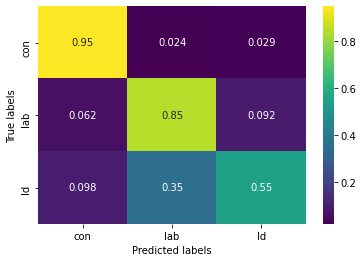

In [38]:
#best_rfc = grid_search_rfc.best_estimator_
best_rfc = saved_best_rfc
kFold_cross_validation_using_SMOTE(features, targets, 5, best_rfc)
print()

<a id=’neural_network’></a>
# Neural Network

Now I'm going to try out our classification problem using a simple feedforward neural network. The learning algorithm I use is mini-batch gradient descent applied over multiple epochs.

To start off with I'll use a network with 4 hidden layers, the first will have 20 nodes and the rest will have 10. In the future I plan to return to this project and optimise the hyperparameters of the neural network using a genetic algorithm as I have in other projects.

I'm going to have to write a few more functions just to get our data in a format that will work with Keras.

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [40]:
def calculate_binary_targets(series, zero_class="con"):
    values = np.array([])
    for index, value in series.iteritems():
        if (value == zero_class):
            values = np.append(values, 0)
        else:
            values = np.append(values, 1)
    return values

def create_dummy_targets(targets):
    no_of_classes = len(pd.unique(targets))
    if (no_of_classes > 2):
        encoder = LabelEncoder()
        encoder.fit(targets.values)
        encoded_Y = encoder.transform(targets.values)
        return np_utils.to_categorical(encoded_Y)
    else:
        return calculate_binary_targets(targets)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train_nn = create_dummy_targets(y_train)
y_test_nn = create_dummy_targets(y_test)

In [42]:
ann = Sequential()
ann.add(Dense(20, input_dim=features.shape[1], activation="relu"))
ann.add(Dense(10, activation="relu"))
ann.add(Dense(10, activation="relu"))
ann.add(Dense(10, activation="relu"))

no_of_classes = len(pd.unique(targets))
if (no_of_classes > 2):
    ann.add(Dense(no_of_classes, activation="softmax"))
else:
    ann.add(Dense(1, activation="softmax"))

ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ann.fit(X_train, y_train_nn, epochs=30, batch_size=5, verbose=1)

Epoch 1/30
5213/5213 [==============================] - 4s 731us/step - loss: 0.4939 - accuracy: 0.7902
Epoch 2/30
5213/5213 [==============================] - 4s 794us/step - loss: 0.4450 - accuracy: 0.8187
Epoch 3/30
5213/5213 [==============================] - 4s 804us/step - loss: 0.4389 - accuracy: 0.8216
Epoch 4/30
5213/5213 [==============================] - 4s 774us/step - loss: 0.4348 - accuracy: 0.8216
Epoch 5/30
5213/5213 [==============================] - 4s 755us/step - loss: 0.4295 - accuracy: 0.8236
Epoch 6/30
5213/5213 [==============================] - 4s 732us/step - loss: 0.4253 - accuracy: 0.8245
Epoch 7/30
5213/5213 [==============================] - 4s 787us/step - loss: 0.4186 - accuracy: 0.8272
Epoch 8/30
5213/5213 [==============================] - 3s 666us/step - loss: 0.4132 - accuracy: 0.8274
Epoch 9/30
5213/5213 [==============================] - 4s 825us/step - loss: 0.4104 - accuracy: 0.8275
Epoch 10/30
5213/5213 [==============================] - 4s 826u

Accuracy score: 0.8417145593869731

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      2152
         1.0       0.86      0.77      0.81      1423
         2.0       0.53      0.76      0.63       601

    accuracy                           0.84      4176
   macro avg       0.78      0.81      0.79      4176
weighted avg       0.86      0.84      0.85      4176




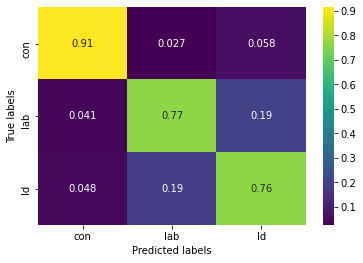

In [43]:
predictions = ann.predict(X_test)
preditions_formatted = np.array([])
for x in range(0, len(predictions)):
    max_val = predictions[x][0]
    max_loc = 0
    for y in range(1, len(predictions[0])):
        if (max_val < predictions[x][y]):
            max_val = predictions[x][y]
            max_loc = y
    preditions_formatted = np.append(preditions_formatted, max_loc)
    
party_name_to_num = {v: k for k, v in party_num_to_name.items()}

y_test_nn_formatted = np.array([])
for i in range(0, len(y_test)):
    y_test_nn_formatted = np.append(y_test_nn_formatted, party_name_to_num[y_test.values[i]] - 1)

print("Accuracy score: " + str(accuracy_score(y_test_nn_formatted, preditions_formatted)))
print()

display_analytics(y_test_nn_formatted, preditions_formatted, ["con", "lab", "ld"])

print()

Here we get a different kind of model. From run to run accuracy differs bouncing around a range of about 83% accuracy to 87%. So on average, this neural network has a slightly lower overall accuracy than the random forest we built before. Interestingly however, SMOTE seems to have been much more effective at making the classifier more balanced. The recall of Labour has decreased by around a bit, however the recall of Liberal Democrats has signifcantly decreased. Though this differs in magnitude between runs.

Therefore if we were classifying samples that were unifromly distributed between the different parties our neural network would be more reliable. However we know this isn't that case as in England in 2019 over 80% of voters either picked Labour or the Conservaties.